In [1]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 4.9 MB 38.8 MB/s 
     |████████████████████████████████| 1.2 MB 40.2 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 352 kB 48.3 MB/s 
     |████████████████████████████████| 596 kB 35.9 MB/s 
     |████████████████████████████████| 1.1 MB 41.9 MB/s 
     |████████████████████████████████| 213 kB 50.0 MB/s 
     |████████████████████████████████| 90 kB 9.7 MB/s 
     |████████████████████████████████| 47.6 MB 2.9 MB/s 
     |████████████████████████████████| 99 kB 8.2 MB/s 


In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras import layers
from keras import models
import keras

tf.get_logger().setLevel('ERROR')
keras.__version__

'2.7.0'

In [3]:
# make sure run in GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
df = pd.read_csv('student_simulation.csv')
df

,gender,race,international_stu,technical_skill,reading_score,Teamwork,Empathy_skills,Self-control,Ability_to_compromise,Ability_to_teach,Respect_for_others,Openness_to_Criticism,Sensitivity_and_Tact,Gaining_trust,Comfort_with_Differences,Listening_Skills
0,female,Hispanic and Latino,domestic,no,4,87,80,97,75,99,77,91,72,92,76,78
1,male,white,domestic,no,2,85,73,83,79,75,64,76,75,74,84,82
2,male,white,domestic,no,1,89,63,87,87,95,88,72,70,81,90,99
3,male,white,domestic,no,1,80,74,77,89,82,79,93,76,89,72,76
4,female,black,domestic,yes,4,66,92,70,78,88,89,77,67,78,75,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,male,white,domestic,no,4,76,82,82,91,79,84,77,78,84,82,77
999996,female,asian,domestic,no,3,81,85,85,78,88,85,93,82,68,62,77
999997,female,Hispanic and Latino,domestic,no,5,85,79,65,77,100,69,91,88,87,70,85
999998,female,white,domestic,no,4,68,85,84,70,73,84,80,83,71,85,66


In [5]:
dt = pd.get_dummies(data=df,columns=['gender','international_stu','technical_skill','race'],drop_first=True)
dt

,reading_score,Teamwork,Empathy_skills,Self-control,Ability_to_compromise,Ability_to_teach,Respect_for_others,Openness_to_Criticism,Sensitivity_and_Tact,Gaining_trust,Comfort_with_Differences,Listening_Skills,gender_male,international_stu_international,technical_skill_yes,race_asian,race_black,race_others,race_white
0,4,87,80,97,75,99,77,91,72,92,76,78,0,0,0,0,0,0,0
1,2,85,73,83,79,75,64,76,75,74,84,82,1,0,0,0,0,0,1
2,1,89,63,87,87,95,88,72,70,81,90,99,1,0,0,0,0,0,1
3,1,80,74,77,89,82,79,93,76,89,72,76,1,0,0,0,0,0,1
4,4,66,92,70,78,88,89,77,67,78,75,78,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4,76,82,82,91,79,84,77,78,84,82,77,1,0,0,0,0,0,1
999996,3,81,85,85,78,88,85,93,82,68,62,77,0,0,0,1,0,0,0
999997,5,85,79,65,77,100,69,91,88,87,70,85,0,0,0,0,0,0,0
999998,4,68,85,84,70,73,84,80,83,71,85,66,0,0,0,0,0,0,1


In [6]:
scaler = StandardScaler()
ds = scaler.fit_transform(dt)
ds

array([[ 7.45751793e-01,  7.76994115e-01, -1.13892189e-03, ...,
        -3.87257729e-01, -2.09521093e-01, -1.19969757e+00],
       [-1.05035974e+00,  5.55027664e-01, -7.78408417e-01, ...,
        -3.87257729e-01, -2.09521093e-01,  8.33543405e-01],
       [-1.94841550e+00,  9.98960565e-01, -1.88879341e+00, ...,
        -3.87257729e-01, -2.09521093e-01,  8.33543405e-01],
       ...,
       [ 1.64380756e+00,  5.55027664e-01, -1.12177421e-01, ...,
        -3.87257729e-01, -2.09521093e-01, -1.19969757e+00],
       [ 7.45751793e-01, -1.33168716e+00,  5.54053575e-01, ...,
        -3.87257729e-01, -2.09521093e-01,  8.33543405e-01],
       [-1.94841550e+00,  1.22092702e+00, -2.22190891e+00, ...,
        -3.87257729e-01, -2.09521093e-01, -1.19969757e+00]])

In [7]:
from __future__ import print_function
import numpy as np
import h5py
import glob
import math
import os
import shutil
from scipy import signal
from scipy.signal import butter, lfilter
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from tensorflow.python.keras.layers import Layer, InputSpec
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.initializers import VarianceScaling
from keras.callbacks import CSVLogger
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')

In [8]:
inp = Input(shape=(19,1))  
e = Conv1D(4, (19, ), activation='tanh', padding='same')(inp)
e = MaxPooling1D((1, ), padding='same')(e)
e = Conv1D(2, (19, ), activation='tanh', padding='same')(e)
e = MaxPooling1D((1, ), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv1D(2, (19, ), activation='tanh', padding='same')(d)
d = UpSampling1D(1)(d)
d = Conv1D(4, (19, ), activation='tanh', padding='same')(d)
d = UpSampling1D(1)(d)
decoded = Conv1D(1, (19, ), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 19, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 19, 4)             80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 4)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 2)             154       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 2)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 38)                

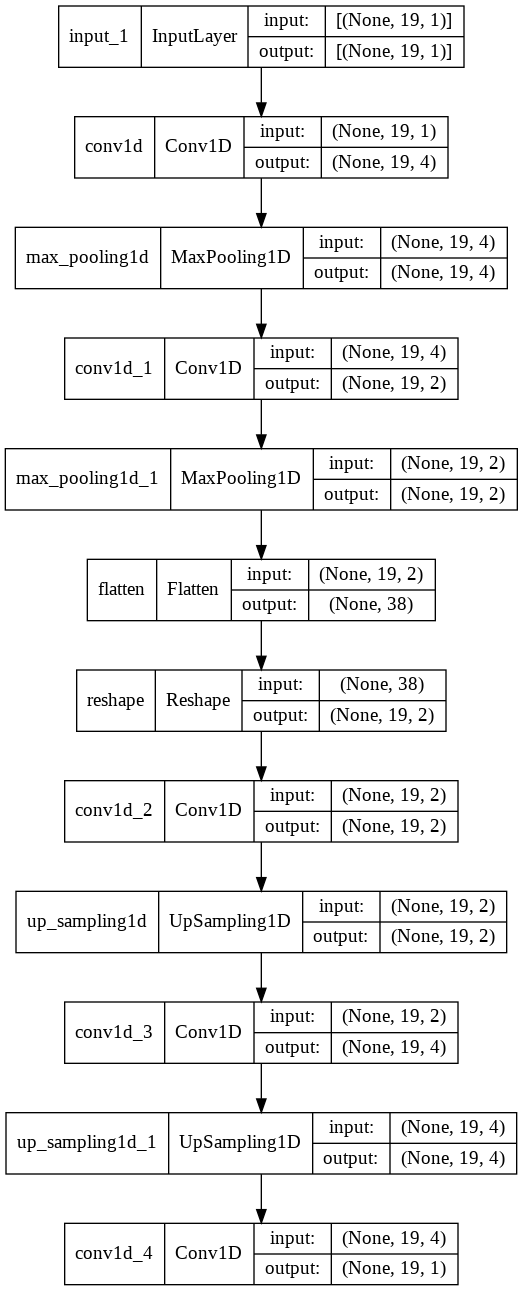

In [10]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot
G = model_to_dot(autoencoder, show_shapes = True)
Image (G.create (prog = "dot", format = "png"))

In [11]:
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(ds, ds, batch_size=128, epochs=10, validation_data=(ds,ds))

Epoch 1/10
7813/7813 [==============================] - 84s 10ms/step - loss: 0.0132 - val_loss: 2.9847e-04
Epoch 2/10
7813/7813 [==============================] - 76s 10ms/step - loss: 1.9449e-04 - val_loss: 1.3813e-04
Epoch 3/10
7813/7813 [==============================] - 75s 10ms/step - loss: 1.1053e-04 - val_loss: 1.2463e-04
Epoch 4/10
7813/7813 [==============================] - 75s 10ms/step - loss: 8.5037e-05 - val_loss: 8.9497e-05
Epoch 5/10
7813/7813 [==============================] - 75s 10ms/step - loss: 7.2863e-05 - val_loss: 7.9785e-05
Epoch 6/10
7813/7813 [==============================] - 94s 12ms/step - loss: 6.3989e-05 - val_loss: 6.8329e-05
Epoch 7/10
7813/7813 [==============================] - 93s 12ms/step - loss: 5.9006e-05 - val_loss: 4.9036e-05
Epoch 8/10
7813/7813 [==============================] - 75s 10ms/step - loss: 5.4574e-05 - val_loss: 5.4052e-05
Epoch 9/10
7813/7813 [==============================] - 93s 12ms/step - loss: 5.1571e-05 - val_loss: 4.0977e

In [26]:
encoder.save('encoder.h5')

In [54]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(ds))

In [55]:
label = pd.DataFrame(y_pred,columns=['label'])
label

,label
0,4
1,3
2,4
3,4
4,2
...,...
999995,4
999996,0
999997,4
999998,3


In [14]:
ds_label = pd.concat([df, label], axis=1)

compression_opts = dict(method='zip', archive_name='data_label.csv')  
ds_label.to_csv('label.zip', index=False, compression=compression_opts)

In [56]:
dd = pd.concat([dt, label], axis=1)

In [21]:
from sklearn.manifold import TSNE

In [57]:
filter_data = dd[0:5000]
label = np.array(filter_data.label)
u_labels_filter = np.unique(filter_data.label)

In [52]:
enc = encoder.predict(ds[0:5000])
redu = TSNE(random_state=123).fit_transform(enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


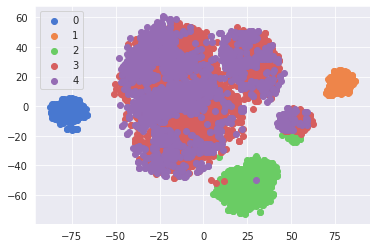

In [58]:
# Plot 5000 samples
for i in u_labels_filter:
    plt.scatter(redu[label==i,0],redu[label==i,1],label=i)
plt.legend()
plt.show()